### An example of the SIGW inverse problem using the GT and MP grid method

In [1]:
import sys
sys.path.append('../')
from jax import vmap, jit, grad, random, jacfwd
import jax.numpy as jnp
import numpy as np
import time
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import warnings
from jax import config
config.update("jax_enable_x64", True)
import numpyro
from interpolation.omega_gw_grid import OmegaGWGrid
from interpolation.model import Fixed_Nodes_Model
import pybobyqa
from getdist import plots,MCSamples,loadMCSamples
%config InlineBackend.figure_format = 'retina'
np.set_printoptions(precision=4,suppress=True)
jnp.set_printoptions(precision=4,suppress=True)
font = {'size'   : 16, 'family':'serif'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True) # if using latex in plots
matplotlib.rc('legend', fontsize=16)


#### A simple test curvature power spectrum and $\Omega_{\rm GW}$

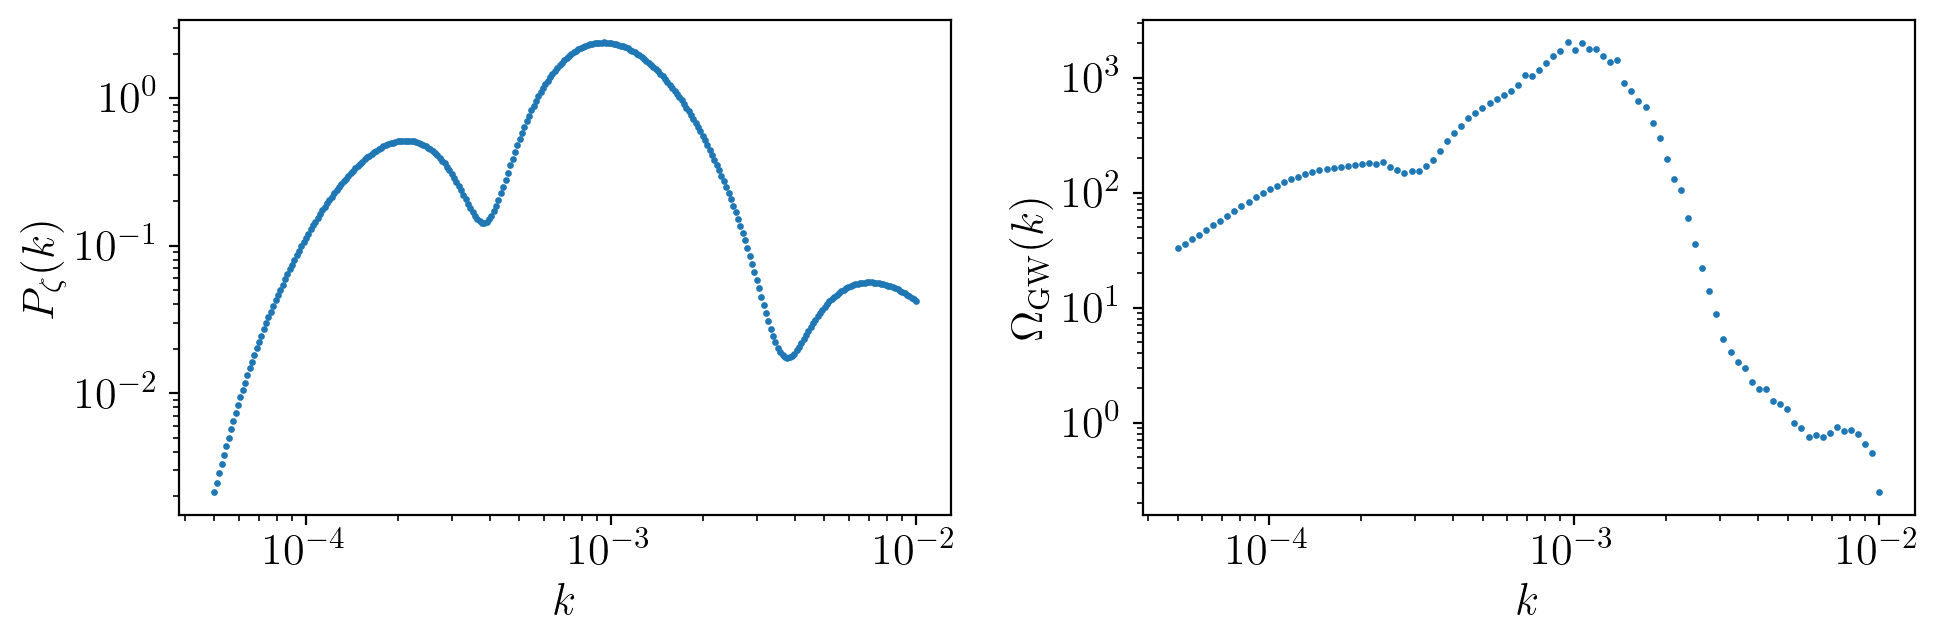

In [3]:
# set up the power spectrum and omgw
psize = 300
ksize = 100
p_arr = np.geomspace(5e-5,1e-2,psize)
k_arr = np.geomspace(5e-5,1e-2,ksize)

def pz(p,pstar=5e-4,n1=3,n2=-2,sigma=2):
    nir = n1
    pl1 = (p/pstar)**nir
    nuv = (n2 - n1)/sigma
    pl2 = (1+(p/pstar)**sigma)**nuv
    osc = (1 + 16.4*jnp.cos(1.4*jnp.log(p/1.))**2)
    return pl1 * pl2 *osc

omgw_calculator = OmegaGWGrid(omgw_karr=k_arr,pz_karr=p_arr)

pz_amp = pz(p_arr)
omgw_amp = omgw_calculator(pz_func=pz,k=k_arr)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,3.5))
ax1.scatter(p_arr,pz_amp,s=2)
ax1.set_ylabel(r'$P_{\zeta}(k)$')
ax2.set_ylabel(r'$\Omega_{\mathrm{GW}}(k)$')
ax2.scatter(k_arr,omgw_amp,s=2)
for ax in [ax1,ax2]:
    ax.set(yscale='log',xscale='log',xlabel=r'$k$')
fig.tight_layout();

#### Let's set up the inference with an uncertainity on the GWB

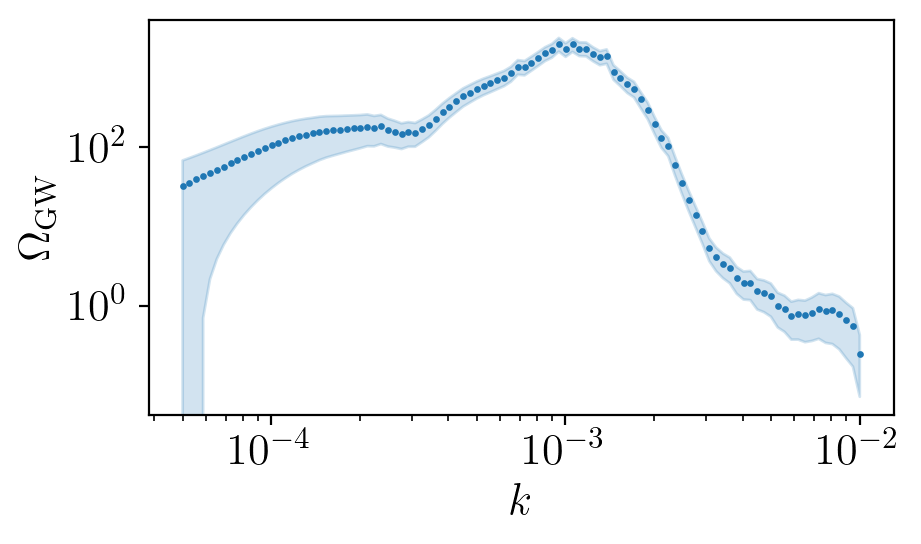

In [4]:
kstar = 1e-3
omks_sigma = omgw_amp*( 0.05*(np.log(k_arr/kstar))**2 + 0.1) # 10% error at kstar + more towards edges
omgw_cov = jnp.diag(omks_sigma**2)
fig,ax = plt.subplots(1,1,figsize=(5,3.))
ax.set_ylabel(r'$\Omega_{\mathrm{GW}}$')
ax.scatter(k_arr,omgw_amp,s=2)
ax.fill_between(k_arr,omgw_amp+1.96*omks_sigma,omgw_amp-1.96*omks_sigma,alpha=0.2,color='C0')
ax.set(yscale='log',xscale='log',xlabel=r'$k$')
fig.tight_layout()

In [18]:
# Set up the fixed node interpolator
kmin, kmax = min(p_arr), max(p_arr)
nbins = 8
pz_model = Fixed_Nodes_Model(nbins=nbins,pz_kmin=kmin,pz_kmax=kmax,
                            omgw_karr=k_arr,omgw_means=omgw_amp,
                            omgw_cov=omgw_cov,omgw_method='grid',y_low=-5,y_high=2)

In [19]:
# run the HMC
samples, _ = pz_model.run_hmc_inference()

sample: 100%|██████████| 512/512 [00:16<00:00, 31.48it/s, 31 steps of size 9.72e-02. acc. prob=0.97]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      y[0]     -4.90      3.52     -4.45    -10.86      0.24    129.49      1.00
      y[1]     -4.59      2.64     -3.90     -8.70     -0.74     88.80      1.01
      y[2]     -0.22      0.39     -0.11     -0.73      0.31     72.10      1.00
      y[3]      0.38      0.07      0.38      0.27      0.49    105.96      1.00
      y[4]      2.23      0.02      2.23      2.20      2.28     95.19      1.00
      y[5]      0.04      0.04      0.04     -0.02      0.11    108.60      1.00
      y[6]     -2.35      0.08     -2.34     -2.47     -2.23    108.82      1.00
      y[7]     -0.93      0.12     -0.91     -1.10     -0.74     97.81      1.00

Number of divergences: 0


#### Now we plot some realisations of the inferred $P_{\zeta}$ from the MCMC samples

(16, 300)
(16, 100)


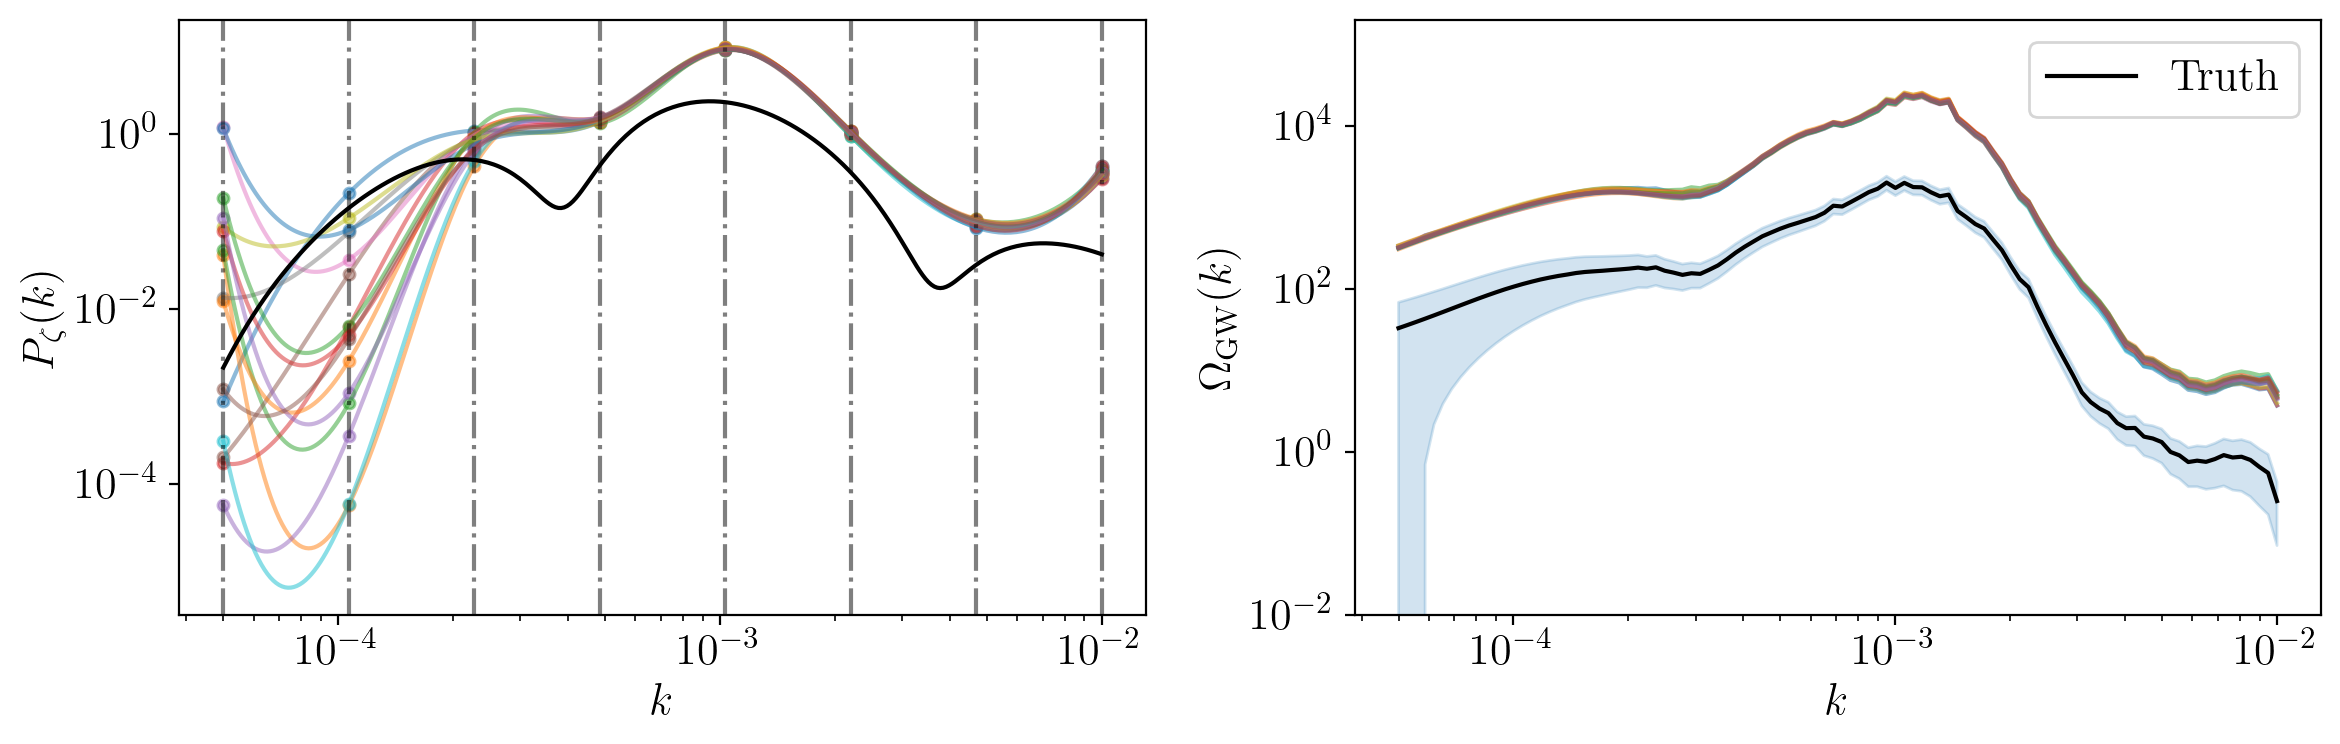

In [22]:
from interpolation.model import spline_predict
nodes = pz_model.log_k_nodes
f = lambda y: spline_predict(x_train=nodes,y_train=y,x_pred=p_arr)
ys = samples['y'][::16]
pz_amps = vmap(f,)(ys)
print(pz_amps.shape)
omgw_amps = jnp.einsum("pi,pj,kij->pk",pz_amps,pz_amps,omgw_calculator.omkij)
print(omgw_amps.shape)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))

for i,pz in enumerate(pz_amps):
    ax1.loglog(p_arr,pz,alpha=0.5)
    ax1.scatter(jnp.exp(nodes),jnp.exp(ys[i]),s=16,alpha=0.5)
for om in omgw_amps:
    ax2.loglog(k_arr,om,alpha=0.5)
ax1.loglog(p_arr,pz_amp,color='k',lw=1.5)
ax2.plot(k_arr,omgw_amp,color='k',lw=1.5,label='Truth')
ax2.fill_between(k_arr,omgw_amp+1.96*omks_sigma,omgw_amp-1.96*omks_sigma,alpha=0.2,color='C0')
ax2.set(yscale='log',xscale='log')

ax1.set_ylabel(r'$P_{\zeta}(k)$')
ax1.set_xlabel(r'$k$')
ax2.set_ylim(1e-2,2e5)

ax2.set_ylabel(r'$\Omega_{\mathrm{GW}}(k)$')
ax2.set_xlabel(r'$k$')
ax2.legend()
for val in nodes:
    ax1.axvline(jnp.exp(val),color='k',ls='-.',alpha=0.5)
fig.tight_layout()

# the dashed lines represent the spline node locations

#### Do an optimization instead of HMC sampling

In [15]:
from interpolation.model import optim_scipy_bh, optim_optax
best_params, _ = optim_scipy_bh(x0 = -3*jnp.ones(nbins),loss = pz_model.loss,bounds=(-7,3),stepsize=0.4,niter=20) 
#best_params, _ =  optim_optax(x0 = -1.5*jnp.ones(5), loss = pz_model.loss, start_learning_rate=0.3 , steps = 200, jump_sdev=1.)
print(best_params)
pz_bf = spline_predict(x_train=nodes,y_train=best_params,x_pred=p_arr)
omgw_bf = jnp.einsum("i,j,kij->k",pz_bf,pz_bf,omgw_calculator.omkij)

[-7.     -2.0132  0.0782  0.3694  2.2288  0.0484 -2.3596 -0.8985]


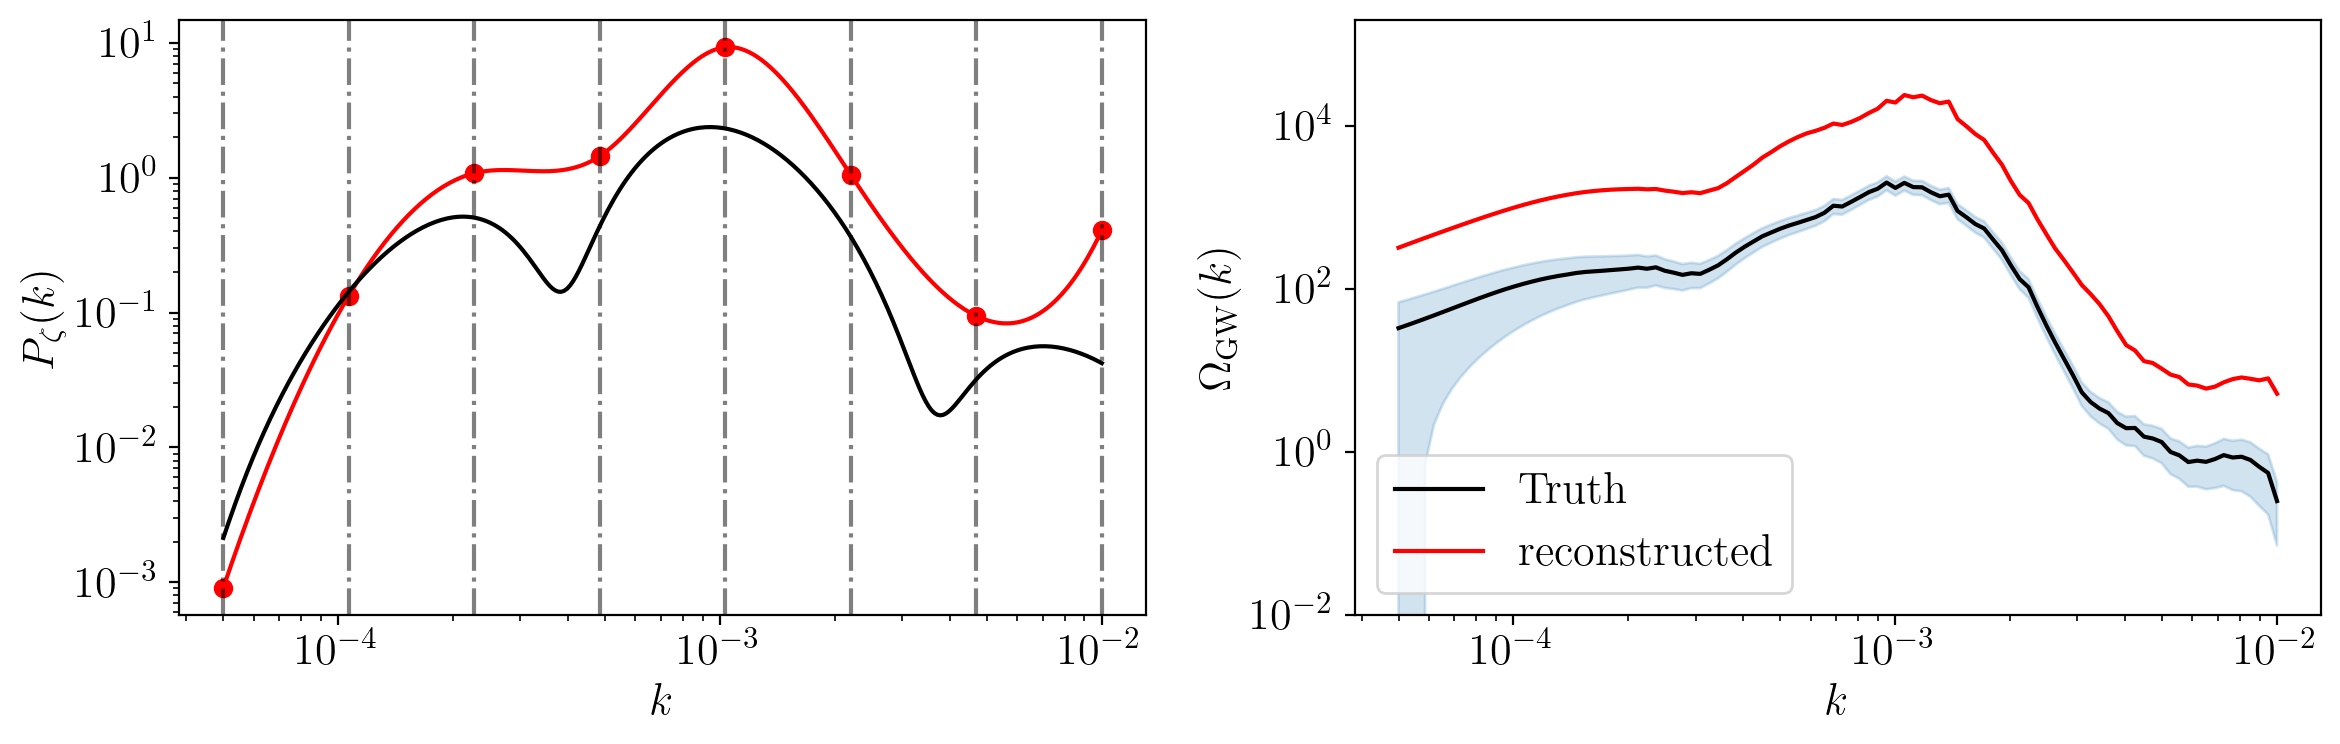

In [17]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))

ax1.loglog(p_arr,pz_bf,color='r')
ax1.loglog(p_arr,pz_amp,color='k',lw=1.5)
ax2.plot(k_arr,omgw_amp,color='k',lw=1.5,label='Truth')
ax2.loglog(k_arr,omgw_bf,color='r',label='reconstructed')
ax2.fill_between(k_arr,omgw_amp+1.96*omks_sigma,omgw_amp-1.96*omks_sigma,alpha=0.2,color='C0')
ax2.set(yscale='log',xscale='log')

ax1.set_ylabel(r'$P_{\zeta}(k)$')
ax1.set_xlabel(r'$k$')
ax2.set_ylim(1e-2,2e5)

ax2.set_ylabel(r'$\Omega_{\mathrm{GW}}(k)$')
ax2.set_xlabel(r'$k$')
ax2.legend()
for val in nodes:
    ax1.axvline(jnp.exp(val),color='k',ls='-.',alpha=0.5)
ax1.scatter(jnp.exp(nodes),jnp.exp(best_params),color='r')
fig.tight_layout()
